In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

import os
import sys
cur_dir = os.path.dirname(os.path.abspath("__file__"))  # Gets the current notebook directory
src_dir = os.path.join(cur_dir, '../')  # Constructs the path to the 'src' directory
# Add the 'src' directory to sys.path
if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.constant import *
from tqdm.notebook import tqdm

from src.MyDataset import MyDataset
from src.TraPredModel import TraPredModel

In [2]:
import torch.utils
import torch.utils.data


lookback = 30
dir = '../data/PandasData/Sampled/'
ds = MyDataset(lookback=lookback)
train_batch_size = 16
test_batch_size = 16

def process_data(df_dir : str, target_freq : int = 10):
    df: pd.DataFrame = pd.read_pickle(df_dir)
    df.dropna(inplace=True, how='any')
    f_per_sec = df.groupby('TimestampID').count().mean().mean()
    if f_per_sec < target_freq:
        raise ValueError('The frequency of the data is lower than the target frequency')
    elif int(f_per_sec) == target_freq:
        pass
    else:
        resample_ratio = int(f_per_sec/target_freq)
        df = df.iloc[::resample_ratio, :]
    # # for origin
    for drop_column in ['Confidence', 'Timestamp', 'TimestampID', 
                          'DatapointID', 'PID', 'SCN', 'U_X', 'U_Y', 'U_Z', 
                          'AGV_Z', 'User_Z', 'GazeOrigin_Z', 'User_Pitch', 'User_Yaw', 'User_Roll', 
                          'EyeTarget']:
        df = df.drop(columns=[drop_column], errors='ignore')

    target_columns = ['User_X', 'User_Y']
    # Reorder columns
    new_columns = target_columns + [col for col in df.columns if col not in target_columns]
    df = df[new_columns]

    return df

for file in os.listdir(dir):
    if file.endswith('.pkl'):
        df = process_data(dir+file)
        ds.read_data(df)


In [3]:
stats_dict = {'mean': 0, 'std': 0, 'min': 0, 'max': 0}
stats_dict = ds.normalize_dataset()
ds.generate_data()

train:torch.utils.data.DataLoader
test:torch.utils.data.DataLoader

train, test = ds.split_data(frac=0.9, shuffle=True, train_batch_size=train_batch_size, test_batch_size=test_batch_size)


feature_dim = ds.feature_dim
print(f"columns : {df.columns} \nfeature_dim : {feature_dim}")

/home/shaoze/Documents/Boeing/Boeing-Trajectory-Prediction/notebook/../src/MyDataset.py:101: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(X), torch.tensor(y)


columns : Index(['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y', 'AGV_speed_X',
       'AGV_speed_Y', 'AGV_speed', 'User_speed_X', 'User_speed_Y',
       'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
       'intent_to_cross', 'Gazing_station', 'possible_interaction',
       'facing_along_sidewalk', 'facing_to_road', 'On_sidewalks', 'On_road',
       'closest_station', 'distance_to_closest_station',
       'distance_to_closest_station_X', 'distance_to_closest_station_Y',
       'looking_at_AGV', 'start_station_X', 'start_station_Y', 'end_station_X',
       'end_station_Y', 'distance_from_start_station_X',
       'distance_from_start_station_Y', 'distance_from_end_station_X',
       'distance_from_end_station_Y', 'facing_start_station',
       'facing_end_station', 'GazeDirection_X', 'GazeDirection_Y',
       'GazeDirection_Z', 'AGV_X', 'AGV_Y', 'AGV_name',
       'looking_at_closest_station', 'rolling_avg'],
      dtype='object') 
feature_dim : 32


In [4]:
for i, (X, y) in enumerate(train):
    print(X.shape, y.shape)
    break

print(len(train), len(test))

torch.Size([16, 30, 32]) torch.Size([16, 30, 32])
4934 549


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GatedResidualNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(input_size, output_size)
        self.gate = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x1 = F.relu(self.fc1(x))
        gate = torch.sigmoid(self.gate(x1))
        x2 = self.fc2(x1)
        return self.fc3(x) + gate * x2
    

class TemporalFusionTransformer(nn.Module):
    def __init__(self, num_features, num_hidden, num_outputs, num_steps):
        super(TemporalFusionTransformer, self).__init__()
        self.encoder_grn = GatedResidualNetwork(num_features, num_hidden, num_hidden)
        self.self_attention = nn.MultiheadAttention(num_hidden, num_heads=8)
        self.decoder_grn = GatedResidualNetwork(num_hidden, num_hidden, num_hidden)
        self.final_linear = nn.Linear(num_hidden, num_outputs * num_steps)
        self.num_steps = num_steps
        self.num_outputs = num_outputs

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        x = self.encoder_grn(x)
        x, _ = self.self_attention(x, x, x, key_padding_mask=mask)
        x = self.decoder_grn(x)
        x = self.final_linear(x)
        x = x.view(batch_size, seq_len, self.num_outputs, self.num_steps)  # Reshape to (batch_size, seq_len, 2 [UserX, UserY], 20 [time_steps])
        return x[:, -1, :, :].permute(0, 2, 1) #[batch_size, num_steps, num_outputs]


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

model = TemporalFusionTransformer(num_features=feature_dim, 
                                  num_hidden=128, num_outputs=2, 
                                  num_steps=lookback)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = nn.MSELoss()

model.to(device)


Using cuda


TemporalFusionTransformer(
  (encoder_grn): GatedResidualNetwork(
    (fc1): Linear(in_features=32, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=32, out_features=128, bias=True)
    (gate): Linear(in_features=128, out_features=128, bias=True)
  )
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (decoder_grn): GatedResidualNetwork(
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (gate): Linear(in_features=128, out_features=128, bias=True)
  )
  (final_linear): Linear(in_features=128, out_features=60, bias=True)
)

In [22]:

n_epochs = 4
eval_step = 1000
future_steps = 20

# model = TraPredModel(input_size=numeric_df.shape[1], lookback=lookback)

save_every = 10000
train_all = len(train)

loss_all = []

now = datetime.now()
folder_name = now.strftime("%b%d_%H-%M-%S")
os.makedirs(f'../model/{folder_name}', exist_ok=True)


for epoch in range(n_epochs):
    model.train()
    for step, (X_batch, y_batch) in tqdm(enumerate(train), total = train_all):
        X_batch = X_batch.float().to(device)
        y_batch = y_batch.float().to(device)
        optimizer.zero_grad()
        
        # if X_batch.shape[0] != model.batch_size:
        #     continue
        
        y_pred = model(X_batch)

        loss = loss_fn(y_pred[:, :future_steps, :2], y_batch[:, :future_steps, :2])
        
        # if torch.isnan(loss):
        #     print("Loss is NaN")
        #     continue
        loss_all.append(loss.item())
        loss.backward()
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Validation
        if (epoch * train_all + step + 1) % save_every == 0:
            print(f"Saving model at epoch {epoch+1}, step {step+1}")

            torch.save(model.state_dict(), f"../model/{folder_name}/model_{epoch+1}_{step+1}.pt")
        
        if (epoch * train_all + step + 1) % eval_step == 0:
            print(f"Start testing")
            with torch.no_grad():
                model.eval()
                all_test = len(test)
                test_rmse_all = []
                for X_test_batch, y_test_batch in tqdm(test):
                    # if X_test_batch.shape[0] != model.batch_size:
                    #     continue
                    X_test_batch = X_test_batch.float().to(device)
                    y_test_batch = y_test_batch.float().to(device)
                    y_pred = model(X_batch)
                    loss = loss_fn(y_pred[:, :future_steps, :2], y_batch[:, :future_steps, :2])
                    test_rmse = torch.sqrt(loss)
                    if not torch.isnan(test_rmse):
                        test_rmse_all.append(test_rmse.item())

                print("Epoch %d: test RMSE %.4f" % (epoch+1, sum(test_rmse_all)/all_test))
            
            model.train()
        



  0%|          | 0/4934 [00:00<?, ?it/s]

Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.3012
Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.2578
Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.2697
Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.2150


  0%|          | 0/4934 [00:00<?, ?it/s]

Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 2: test RMSE 0.2433
Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 2: test RMSE 0.1931
Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 2: test RMSE 0.1022
Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 2: test RMSE 0.1193
Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 2: test RMSE 0.0977


  0%|          | 0/4934 [00:00<?, ?it/s]

Saving model at epoch 3, step 132
Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 3: test RMSE 0.0926
Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 3: test RMSE 0.0909
Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 3: test RMSE 0.0870
Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 3: test RMSE 0.0532
Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 3: test RMSE 0.0541


  0%|          | 0/4934 [00:00<?, ?it/s]

Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 4: test RMSE 0.0626
Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 4: test RMSE 0.0538
Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 4: test RMSE 0.0633
Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 4: test RMSE 0.0506
Start testing


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 4: test RMSE 0.0664


In [24]:
validation_step = 20

predictions = []
truths = []

with torch.no_grad():
    model.eval()
    all_test = len(test)
    test_rmse_all = []
    for X_test_batch, y_test_batch in tqdm(test):
        # if X_test_batch.shape[0] != model.batch_size:
        #     continue
        X_test_batch = X_test_batch.float().to(device)
        y_test_batch = y_test_batch.float().to(device)
        y_pred = model(X_test_batch)
        predictions.append(y_pred[:, :validation_step, :2])
        truths.append(y_test_batch[:, :validation_step, :2])
        
predictions = torch.cat(predictions, dim=0)
truths = torch.cat(truths, dim=0)

  0%|          | 0/549 [00:00<?, ?it/s]

In [25]:
normalize_dict = stats_dict

for idx, key_ in enumerate(["User_X", "User_Y"]):
    predictions[:, :, idx] = predictions[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    predictions[:, :, idx] = predictions[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
    truths[:, :, idx] = truths[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    truths[:, :, idx] = truths[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]

/home/shaoze/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shaoze/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shaoze/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/shaoze/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-

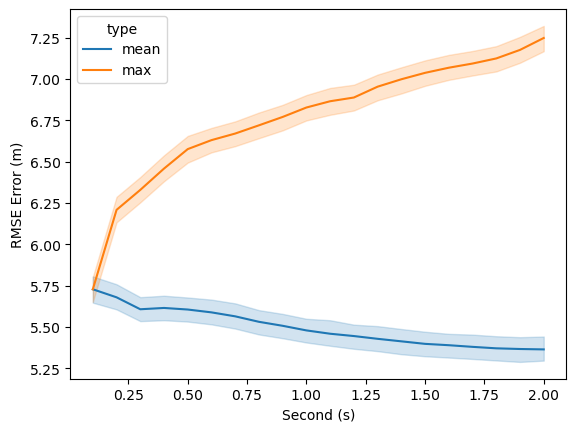

In [27]:
criterion = nn.MSELoss(reduction="none")

steps = []
loss = []
max_loss = []
for step in range(1, 21):
    raw_rmse_loss = criterion(predictions[:, :step, :], truths[:, :step, :])
    raw_rmse_loss = torch.sqrt(torch.sum(raw_rmse_loss, dim=-1))
    mean_rmse_loss = raw_rmse_loss.mean(dim=-1)
    max_rmse_loss = raw_rmse_loss.max(dim=-1).values
    loss.append(mean_rmse_loss)
    max_loss.append(max_rmse_loss)
    steps.extend([step] * len(mean_rmse_loss))
    
max_loss = torch.cat(max_loss).cpu().numpy()
loss = torch.cat(loss).cpu().numpy()

df = pd.DataFrame({'Second (s)': steps, 'loss': loss})
df1 = pd.DataFrame({'Second (s)': steps, 'loss': max_loss})
df['type'] = 'mean'
df1['type'] = 'max'
df = pd.concat([df, df1])


df['RMSE Error (m)'] = df['loss'] / 100 # to meters
df['Second (s)'] = df['Second (s)'] / 10 # to seconds
sns.lineplot(data = df, x='Second (s)', y='RMSE Error (m)', hue='type')
plt.savefig('../figure/TFT_manual.png')
plt.show()